In [10]:
import matplotlib.pyplot as plt # for plotting
from tmaze_toolkit.data.extraction import selectDoorCoords, extractDoorTraces, initial_coords
from tmaze_toolkit.processing.signal import bandpass_filter, process_door_traces, gaussian_filter
from tmaze_toolkit.visualization.plotDoorTraces import plotDoorTraces
from tmaze_toolkit.data.openFunctions import openDoorTracesPkl
from tmaze_toolkit.processing.extractTrialTimes import extract_floor_traces, extract_trial_times, verify_correct_trial_times
from tmaze_toolkit.data.jsonProcessing import load_json_files, add_trajectories, save_outDict
from tmaze_toolkit.visualization.plotTrajectory import plot_trajectory, plot_trajectory_all_trials, plot_multiple_bodyparts
from tmaze_toolkit.processing.normalize import normalize_trajectory
from tmaze_toolkit.data.analysisTools import find_percent_correct, find_trial_length, save_trial_duration, load_trial_duration

In [2]:
pkl_file = r"N:\TMAZE\MasterMouseFolder\ATO1\Clipped Videos\ATO1_2025-03-22T18_28_44_doorTraces.pkl"


In [6]:
dat = openDoorTracesPkl(pkl_file)

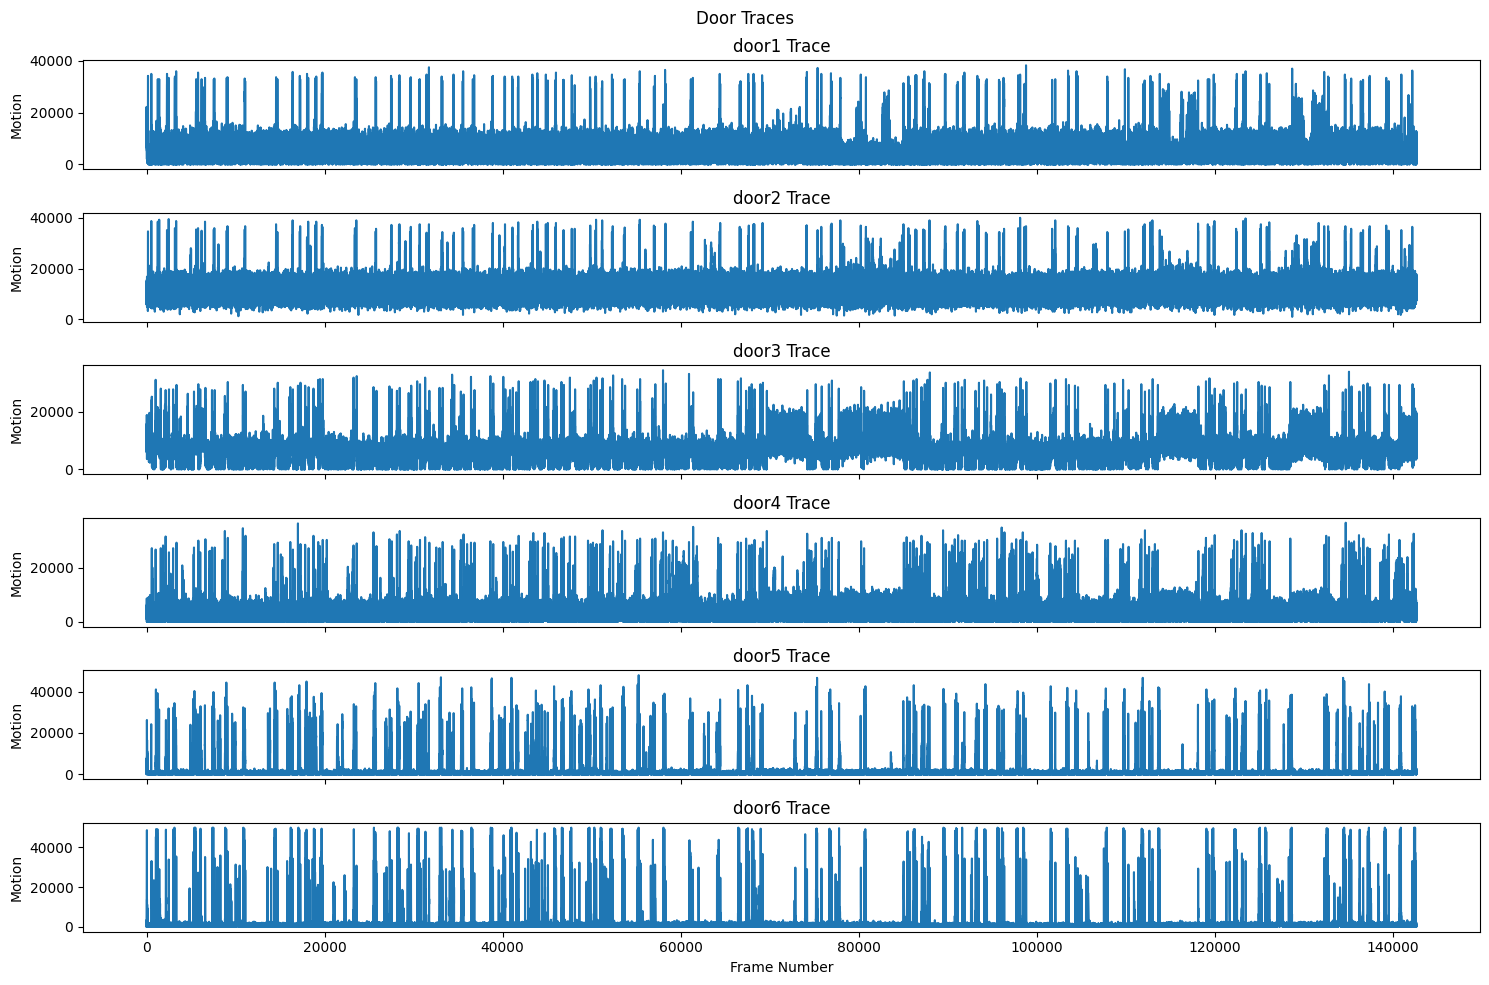

In [4]:
plotDoorTraces(dat)

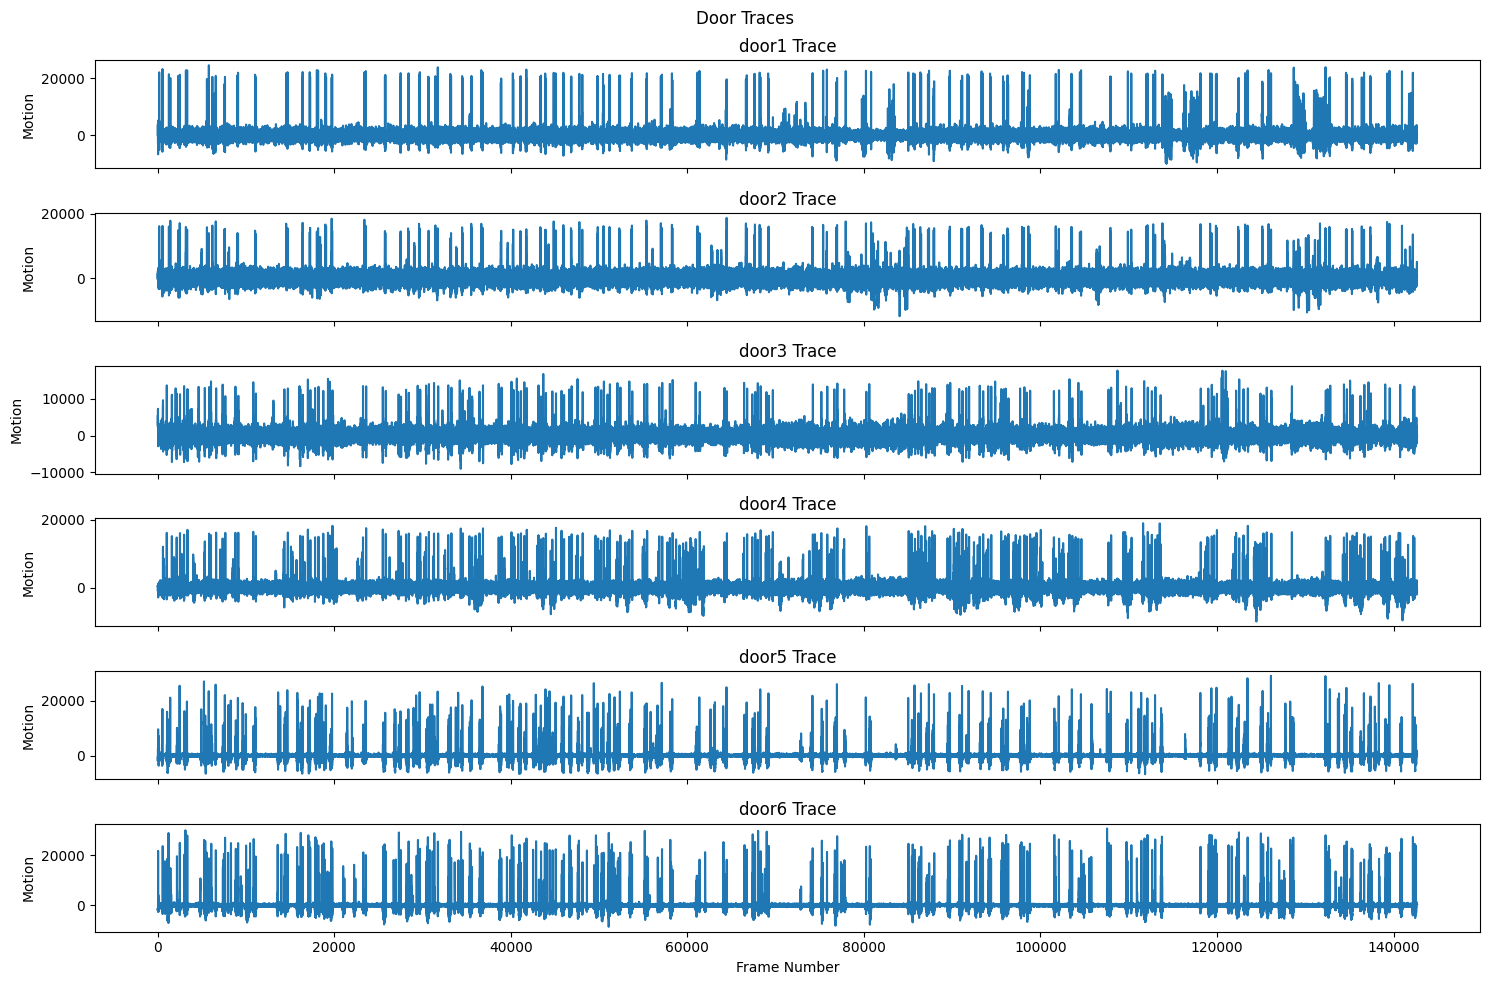

In [8]:
y = bandpass_filter(dat)
plotDoorTraces(y)
# plot 2.5 standard deviations on this figure for each trace


In [13]:
import numpy as np
def process_door_traces(door_traces, lowcut=0.1, highcut=3.0, fs=30.0, order=4, n_std = 2.5, plot=False):
    """
    Process door traces by applying a band-pass filter.
    
    Parameters:
    -----------
    door_traces : dict
        Dictionary containing door traces, where keys are door names and values are lists of motion values.
    lowcut : float, optional
        Low cutoff frequency in Hz, default is 0.1 Hz.
    highcut : float, optional
        High cutoff frequency in Hz, default is 3.0 Hz.
    fs : float, optional
        Sampling frequency in Hz, default is 30.0 Hz (assuming 30 fps video).
    order : int, optional
        Order of the filter, default is 4.
    n_std : float, optional
        Strength of Signal Detector, default motion detection is signal greater than 2.5 standard deviations from the mean. 
    
    Returns:
    --------
    dict
        Dictionary with processed door traces.
    """
    # First, normalize by subtracting the mean
    normalized_traces = {}
    for key in door_traces.keys():
        trace_array = np.array(door_traces[key])
        normalized_traces[key] = trace_array - np.mean(trace_array)
    
    # Apply the band-pass filter to the normalized traces
    filtered_traces = bandpass_filter(normalized_traces, lowcut, highcut, fs, order)

    # Apply a Gaussian filter to the filtered traces
    filtered_traces = gaussian_filter(filtered_traces)

    # Calculate thresholds based on statistics for each door
    thresholds = {}

    for key in filtered_traces.keys():
        mean = np.mean(filtered_traces[key])
        std = np.std(filtered_traces[key])
        # Calculate mean and standard deviation of the trace
        if key == 'door5' or key == 'door6':
            n_std = 2 # This value can be adjusted to change sensitivity
        else:
            n_std = 2.5 # This value can be adjusted to change sensitivity
        #Set threshold as mean plus n standard deviations
        # Can adjust n to be more or less strict based on sensitivity needs
        
        thresholds[key] = mean + (n_std * std)

    if plot:
        fig, axs = plt.subplots(6, 1, figsize=(15, 10), sharex=True)
        fig.suptitle('Thresholds over Door Traces')

        for i, (door, trace) in enumerate(filtered_traces.items()):
            axs[i].plot(trace)
            axs[i].axhline(thresholds[door], color='r', linestyle='--', label='Threshold')
            axs[i].set_title(f'{door} Trace with Threshold')
            axs[i].set_ylabel('Motion')
            axs[i].legend()

        axs[-1].set_xlabel('Frame Number')  
    
    for key in filtered_traces.keys():
        for i in range(len(filtered_traces[key])):
            if filtered_traces[key][i] > thresholds[key]:
                filtered_traces[key][i] = 1;
            else:
                filtered_traces[key][i] = 0;
    
    

    return filtered_traces

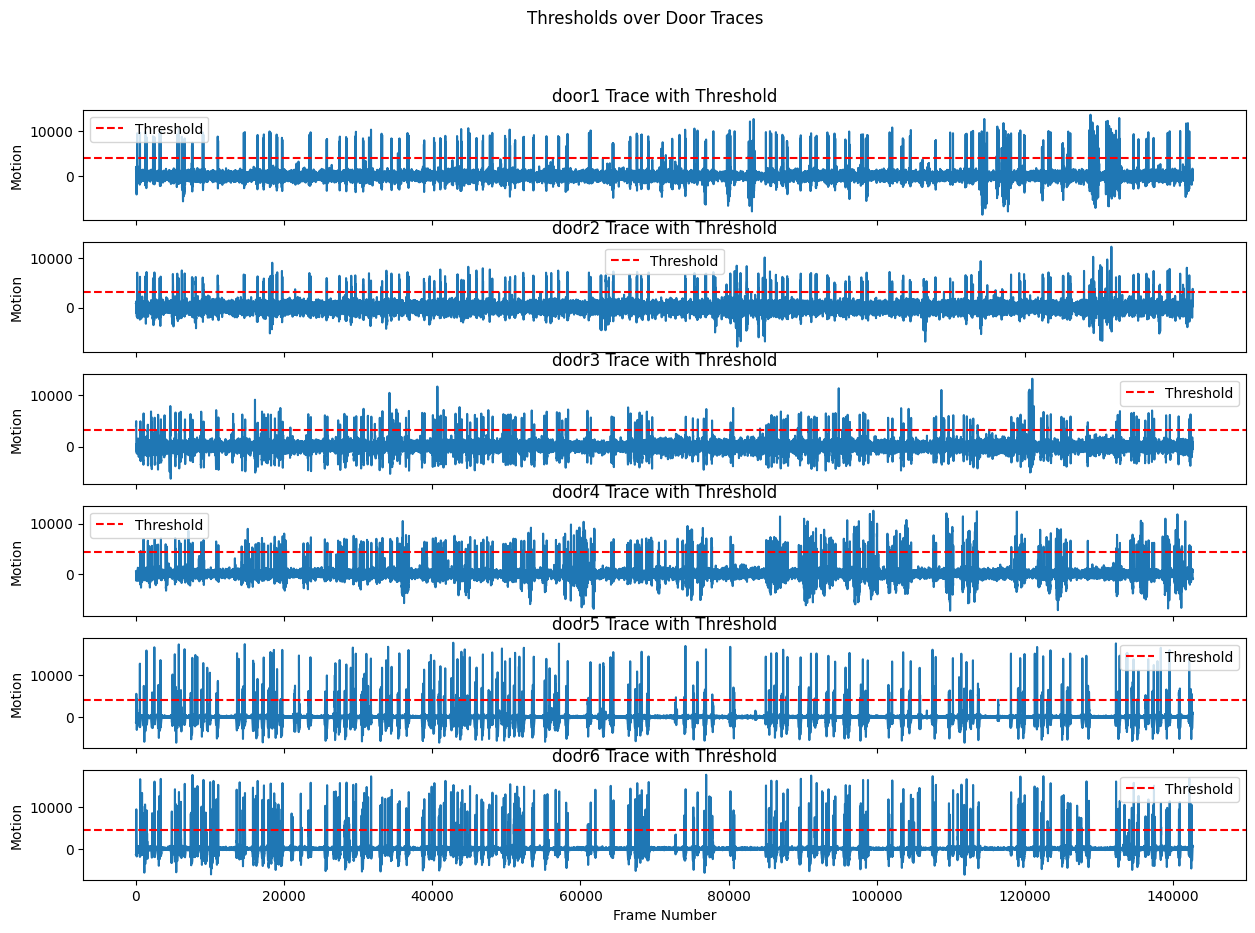

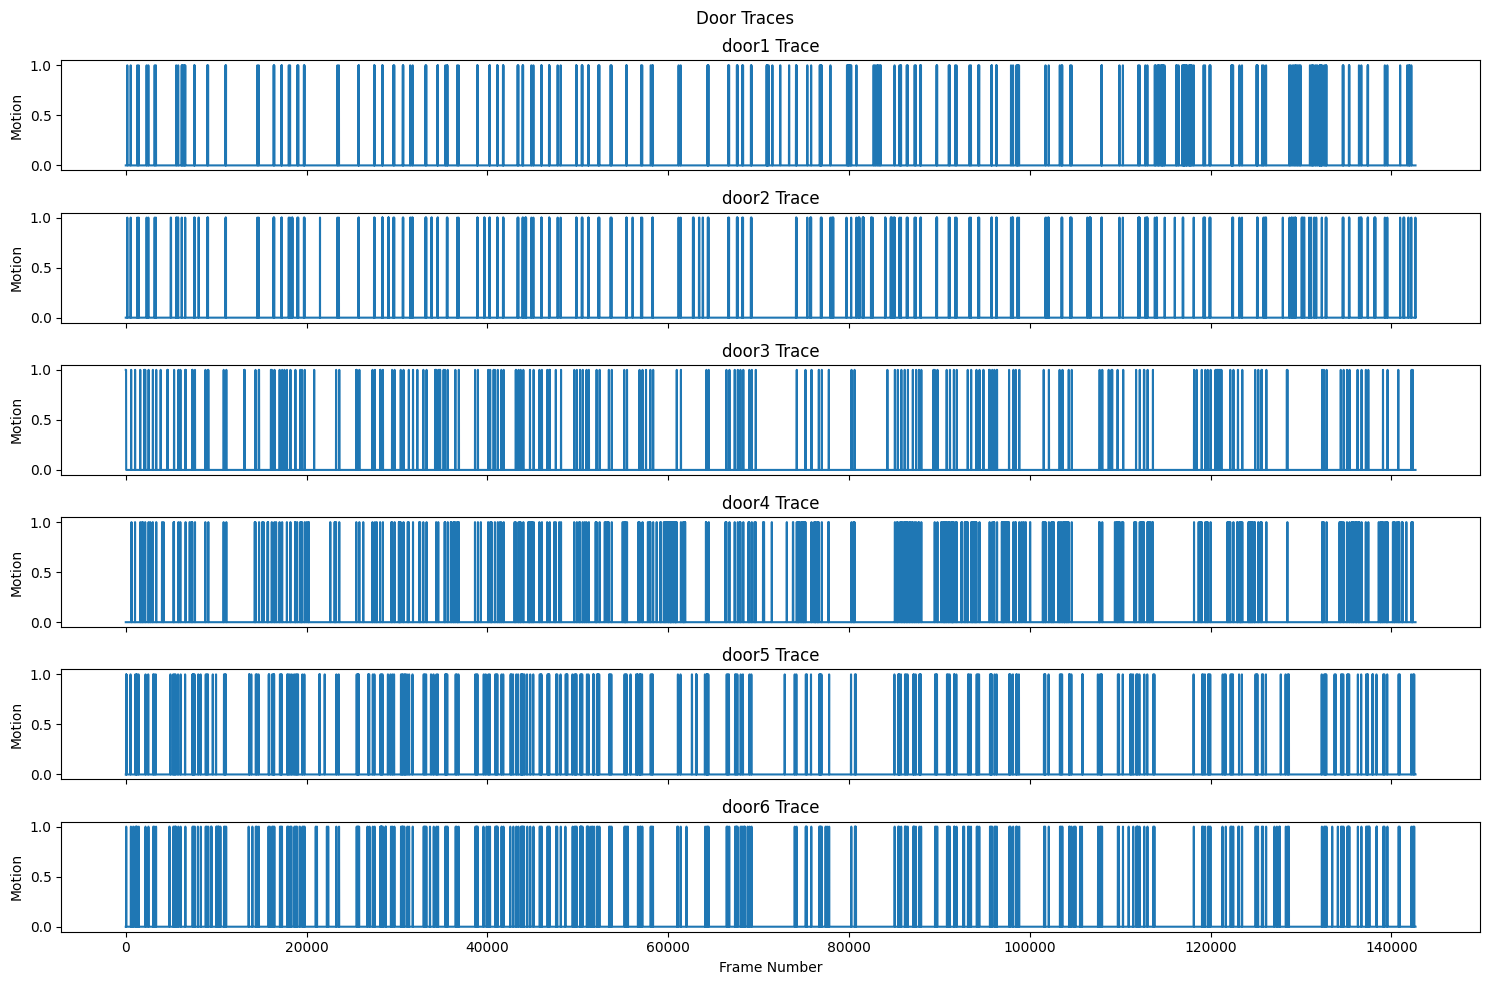

In [15]:
x = process_door_traces(dat, plot=True)
plotDoorTraces(x)

In [ ]:
import pandas as pd
from tmaze_toolkit.data.jsonProcessing import load_json_files
def find_concurrent_events(trace1, trace2, window_frames=15):
    """
    Find distinct trial events when two doors move concurrently.
    
    Args:
        trace1 (list): First door trace (binary 0/1 values)
        trace2 (list): Second door trace (binary 0/1 values)
        window_frames (int): Window size to check for concurrent movement
        
    Returns:
        List of frame indices where distinct events start
    """
    events = []  # Store frame numbers where events start
    i = 0  # Initialize frame counter
    
    # Loop through the traces, stopping window_frames before the end to prevent overflow
    while i < len(trace1) - window_frames:
        # Get a slice of frames to check for concurrent movement
        window1 = trace1[i:i+window_frames]  # Window for first door
        window2 = trace2[i:i+window_frames]  # Window for second door
        
        # Check if both doors show any movement (1's) in their windows
        if 1 in window1 and 1 in window2:
            # If both doors moved, record the start frame of this window
            events.append(i)
            # Skip ahead by the window size to avoid detecting the same event multiple times
            i += window_frames
        else:
            # If no concurrent movement, check the next frame
            i += 1
            
    return events

def pad_movement(floor, window_pad):
    for x in range(len(floor) - window_pad):
        if floor[x] == 1:
            # Search for the next 1 in the next window_pad frames
            for y in range(x + 1, x + window_pad):
                if floor[y] == 1:
                    # If a 1 is found, set all values in between to 1
                    for z in range(x + 1, y):
                        floor[z] = 1
                    break
    return floor

def extract_floor_traces(dat, pad_frames=90):
    floor1 = pad_movement(dat['door5'], pad_frames)
    floor2 = pad_movement(dat['door6'], pad_frames)
    floor_traces = []

    # Add floor1 [x] to floor2 [x]
    for x in range(len(floor1)):
        floor_traces.append(floor1[x] + floor2[x])
    
    floor_starts = []
    floor_ends = []
    isMoving = False
    for x in range(len(floor_traces)):
        if floor_traces[x] == 2:
            if isMoving == False:
                floor_starts.append(x)
                isMoving = True
        if floor_traces[x] < 2:
            if isMoving == True:
                floor_ends.append(x)
                isMoving = False
    
    return floor_starts, floor_ends

def clean_trial_events(starts, ends, window_frames):
    """
    Clean trial events to ensure proper sequencing (start -> end -> start -> end)
    
    Args:
        starts (list): Frame numbers of potential trial starts
        ends (list): Frame numbers of potential trial ends
        window_frames (int): Window size used for detection
        
    Returns:
        tuple: Lists of cleaned trial starts and ends
    """
    cleaned_starts = []
    cleaned_ends = []
    last_end = 0
    
    i, j = 0, 0  # Indices for starts and ends lists
    
    while i < len(starts) and j < len(ends):
        current_start = starts[i]
        current_end = ends[j]

        
        # If we find a valid start (after last end) and its corresponding end
        if current_start > last_end and current_end > current_start:
            cleaned_starts.append(current_start)
            cleaned_ends.append(current_end)
            last_end = current_end
            i += 1
            j += 1
        # Skip invalid starts (before last end)
        elif current_start <= last_end:
            i += 1
        # Skip ends that come before their start
        elif current_end <= current_start:
            j += 1

    while i < len(starts) and j < len(ends):
        current_start = starts[i]
        current_end = ends[j]
            
    return cleaned_starts, cleaned_ends

def extract_trial_times(dat, window_frames=15, pad_frames=90, fps=30, use_floor_traces=False):
    floor_starts, floor_ends = extract_floor_traces(dat, pad_frames)
    trial_starts = find_concurrent_events(dat['door1'], dat['door2'], window_frames)
    trial_ends = find_concurrent_events(dat['door3'], dat['door4'], window_frames)
   
    cleaned_starts, cleaned_ends = clean_trial_events(trial_starts, trial_ends, window_frames)

    print(f"Floor Starts: {len(floor_starts)}")
    print(f"Floor Ends: {len(floor_ends)}")

    print(f"Trial Starts: {len(cleaned_starts)}")
    print(f"Trial Ends: {len(cleaned_ends)}")

    if use_floor_traces:
        cleaned_starts, cleaned_ends = clean_trial_events(floor_starts, floor_ends, window_frames)
    

    floors_trials_df = pd.DataFrame({
        'trial_start_frame': floor_starts,
        'trial_end_frame': floor_ends,
        'trial_start_time': [frame/fps for frame in floor_starts],
        'trial_end_time': [frame/fps for frame in floor_ends],
        'trial_duration': [(end - start)/fps for start, end in zip(floor_starts, floor_ends)]
    })

    trials_df = pd.DataFrame({
        'trial_start_frame': cleaned_starts,     # Frame numbers where trials begin
        'trial_end_frame': cleaned_ends,         # Frame numbers where trials end
        'trial_start_time': [frame/fps for frame in cleaned_starts],  # Convert frames to seconds
        'trial_end_time': [frame/fps for frame in cleaned_ends]       # Convert frames to seconds
    })
    for i in range(len(trials_df)):
        if abs(trials_df['trial_end_frame'][i] - floors_trials_df['trial_start_frame'][i]) > 60:
            print(f"Trial {i} likely has a missed detection in the doors 1 and 2")

    return trials_df


def verify_correct_trial_times(trial_df, jsonFileLocation):
    """
    Verify the correctness of the trial times by comparing them to the json file
    Args:
        trial_df: pandas dataframe, the dataframe containing the trial times
        jsonFileLocation: string, the location of the json file
    Returns:
        bool: True if the trial times are correct, False otherwise
    """
    json_files = load_json_files(jsonFileLocation)
    
    if (len(json_files) - 1) != len(trial_df):
        print(f"Warning: Number of trials in the json file and the trial dataframe do not match")
        return False
    
    else:
        print("Trial times verified successfully")
        return True

In [ ]:
def findTrialTimes(doorTraces):
    # Find when Doors 1 and 2 are moving at the same time
    # Find when Doors 3 and 4 are moving at the same time
    # Find when the floor starts moving and stops moving
    find_floor_movements

In [ ]:
def pad_movement(floor, window_pad):
    for x in range(len(floor) - window_pad):
        if floor[x] == 1:
            # Search for the next 1 in the next window_pad frames
            for y in range(x + 1, x + window_pad):
                if floor[y] == 1:
                    # If a 1 is found, set all values in between to 1
                    for z in range(x + 1, y):
                        floor[z] = 1
                    break
    return floor

In [ ]:
dat = openDoorTracesPkl(pkl_file)
dat = process_door_traces(dat)
events = extract_trial_times(dat, use_floor_traces=False,pad_frames=120)